In [150]:
import pickle as pkl
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go
import seaborn as sns

from numpy.random import gamma, binomial
import numpy as np
import scipy
import pandas as pd 
import xarray as xr 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from convCNP.validation.utils import get_dists
import os
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import xarray as xr

from convCNP.models.elev_models import TmaxBiasConvCNPElev, GammaBiasConvCNPElev
from convCNP.models.cnn import CNN, ResConvBlock
from convCNP.training.training_elev import train_elev
from convCNP.training.loss_functions import gll, gamma_ll
from convCNP.training.utils import get_value_tmax
from convCNP.validation.utils import get_dists

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Data and mode parameters
VARIABLE = 'tmax'   # 'tmax' or 'precip'
DATA_YEAR_START = 2023  # Year to start loading data from, None to include all data
                        # Used for quicker testing

# Model parameters
N_CHANNELS = 128    # default in paper is 128
N_BLOCKS = 6        # default in paper is 6
KERNEL_SIZE = 5     # default in paper is 5
LENGTH_SCALE = 0.1  # default in paper is 0.1
IN_CHANNELS = 25    # default in paper is 25

# Training parameters
N_EPOCHS = 100      # default in paper is 100
BATCH_SIZE = 16     # default in paper is 16    # TODO: wire this in
LR = 5e-4           # default in paper is 5e-4
PATIENCE = 10       # default in paper is 10    # TODO: wire this in

# Cross-validation parameters
N_FOLDS = 5         # default in paper is 5

# Other parameters
SEED = 42

In [117]:
OUTPUT_DIR = 'trained_models/'

# Auto-set data paths based on variable
if VARIABLE == 'tmax':
    GRID_INPUTS, GRID_TARGETS = f'./datasets/ERA5_Land/max_temperature/*.nc', f'./datasets/EOBS/max_temperature/*.nc'
elif VARIABLE == 'precip':
    GRID_INPUTS, GRID_TARGETS = f'./datasets/ERA5_Land/precipitation/*.nc', f'./datasets/EOBS/precipitation/*.nc'
ELEV_INPUTS = ''  # Empty for now

In [118]:
# Load data
full_input_ds = xr.open_mfdataset(GRID_INPUTS, combine='by_coords')
full_target_ds = xr.open_mfdataset(GRID_TARGETS, combine='by_coords')

print("Input data:\n", full_input_ds)
print("\nTarget data:\n", full_target_ds)

Input data:
 <xarray.Dataset> Size: 166MB
Dimensions:    (time: 23376, latitude: 29, longitude: 61)
Coordinates:
  * time       (time) datetime64[ns] 187kB 1960-01-01 1960-01-02 ... 2023-12-31
  * latitude   (latitude) float64 232B 48.2 48.1 48.0 47.9 ... 45.6 45.5 45.4
  * longitude  (longitude) float64 488B 5.0 5.1 5.2 5.3 ... 10.7 10.8 10.9 11.0
Data variables:
    t2m_max    (time, latitude, longitude) float32 165MB dask.array<chunksize=(366, 29, 61), meta=np.ndarray>

Target data:
 <xarray.Dataset> Size: 122MB
Dimensions:    (time: 19540, latitude: 30, longitude: 52)
Coordinates:
  * time       (time) datetime64[ns] 156kB 1971-01-01 1971-01-02 ... 2024-06-30
  * latitude   (latitude) float64 240B 45.35 45.45 45.55 ... 48.05 48.15 48.25
  * longitude  (longitude) float64 416B 5.65 5.75 5.85 ... 10.55 10.65 10.75
Data variables:
    t_max      (time, latitude, longitude) float32 122MB dask.array<chunksize=(1, 30, 52), meta=np.ndarray>
Attributes:
    CDI:            Climate Data Int

In [119]:
# Select data from YEAR_START onwards
if DATA_YEAR_START is not None:
    input_ds = full_input_ds.sel(time=slice(str(DATA_YEAR_START), None))
    target_ds = full_target_ds.sel(time=slice(str(DATA_YEAR_START), None))
else:
    input_ds = full_input_ds
    target_ds = full_target_ds

print("Input data xarray:\n", input_ds)
print("\nTarget data xarray:\n", target_ds)

# create a torch tensor with dimensions (time, lat, long)


Input data xarray:
 <xarray.Dataset> Size: 88MB
Dimensions:    (time: 12418, latitude: 29, longitude: 61)
Coordinates:
  * time       (time) datetime64[ns] 99kB 1990-01-01 1990-01-02 ... 2023-12-31
  * latitude   (latitude) float64 232B 48.2 48.1 48.0 47.9 ... 45.6 45.5 45.4
  * longitude  (longitude) float64 488B 5.0 5.1 5.2 5.3 ... 10.7 10.8 10.9 11.0
Data variables:
    t2m_max    (time, latitude, longitude) float32 88MB dask.array<chunksize=(365, 29, 61), meta=np.ndarray>

Target data xarray:
 <xarray.Dataset> Size: 79MB
Dimensions:    (time: 12600, latitude: 30, longitude: 52)
Coordinates:
  * time       (time) datetime64[ns] 101kB 1990-01-01 1990-01-02 ... 2024-06-30
  * latitude   (latitude) float64 240B 45.35 45.45 45.55 ... 48.05 48.15 48.25
  * longitude  (longitude) float64 416B 5.65 5.75 5.85 ... 10.55 10.65 10.75
Data variables:
    t_max      (time, latitude, longitude) float32 79MB dask.array<chunksize=(1, 30, 52), meta=np.ndarray>
Attributes:
    CDI:            Climate

In [133]:
def calculate_dists(era5_inputs, eobs_targets):
    """
    Get the distances between the grid points and true points.
    """
    era5_long_grid, era5_lat_grid = np.meshgrid(era5_inputs['longitude'], era5_inputs['latitude'])
    era5_lat_grid = torch.from_numpy(era5_lat_grid).to(device)
    era5_long_grid = torch.from_numpy(era5_long_grid).to(device)

    eobs_coords = eobs_targets.stack(coords=['latitude', 'longitude'])['coords'].values

    return get_dists(eobs_coords, era5_lat_grid, era5_long_grid)

dists = calculate_dists(input_ds, target_ds).to(device)

In [134]:
def build_model(variable, n_channels, n_blocks, kernel_size, length_scale, in_channels):
    """
    Build convCNP model based on variable type

    Returns:
        model: nn.Module
        loss_fn: function
        get_value_fn: function to extract predictions from model output
    """
    # Build CNN decoder (same architecture for both variables)
    decoder = CNN(
        n_channels=n_channels,
        ConvBlock=ResConvBlock,
        n_blocks=n_blocks,
        Conv=nn.Conv2d,
        Normalization=nn.Identity,
        kernel_size=kernel_size
    )

    # Build model based on variable
    if variable == 'tmax':
        print("Building TmaxBiasConvCNPElev model...")
        model = TmaxBiasConvCNPElev(
            decoder=decoder,
            in_channels=in_channels,
            ls=length_scale
        )
        loss_fn = gll
        get_value_fn = get_value_tmax

    elif variable == 'precip':
        print("Building GammaBiasConvCNPElev model...")
        model = GammaBiasConvCNPElev(
            decoder=decoder,
            in_channels=in_channels,
            ls=length_scale
        )
        loss_fn = gamma_ll
        # For precipitation, we need a custom function
        def get_value_precip(p):
            """Extract mean prediction for precipitation"""
            # For Gamma distribution, mean = alpha / beta
            # Only predict non-zero when rho > 0.5
            mean = p[:, :, 1] / p[:, :, 2]  # alpha / beta
            mean[p[:, :, 0] <= 0.5] = 0  # Set to 0 when dry
            return mean
        get_value_fn = get_value_precip

    else:
        raise ValueError(f"Unknown variable: {variable}")

    # Count parameters
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has {n_params:,} trainable parameters")

    return model, loss_fn, get_value_fn

In [135]:
def set_seed(seed):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [138]:
# Create output directory if it doesn't exist
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)

# Create a flat elevation map
# elev = torch.zeros(input_ds.sizes['latitude'], input_ds.sizes['longitude']).to(device)
num_target_points = target_ds.sizes['latitude'] * target_ds.sizes['longitude']
elev = torch.zeros(num_target_points, 3).to(device)

# Loop over cross-validation folds
for fold in range(N_FOLDS):
    print(f'\nStarting fold {fold + 1}/{N_FOLDS}...\n')

    # Reset model weights and optimizer for each fold
    set_seed(SEED + fold)  # Use a different seed for each fold for robustness
    model, loss_fn, get_value_fn = build_model(VARIABLE, N_CHANNELS, N_BLOCKS, KERNEL_SIZE, LENGTH_SCALE, IN_CHANNELS)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Note: fold splitting logic is inside train_elev
    print(f'Input dimensions: {input_ds.sizes}')
    
    train_input_ds = torch.from_numpy(input_ds['t2m_max'].values).unsqueeze(1).to(device)
    # Silly way to simulate 25 channels, we will need to properly add channels like in page 9 of the paper
    train_input_ds = train_input_ds.repeat(1, IN_CHANNELS, 1, 1).to(device)
    train_target_ds = torch.from_numpy(target_ds['t_max'].values).to(device)
    # Reshaping from (time, latitude, longitude) to (time, latitude * longitude)
    train_target_ds = train_target_ds.reshape(train_target_ds.shape[0], -1)
    
    # Train the model
    train_elev(
        model=model,
        opt=optimizer,
        ll=loss_fn,
        elev=elev,
        dists=dists,
        y_context=train_input_ds,
        y_target=train_target_ds,
        output_dir=OUTPUT_DIR,
        y_target_t=None,  # did not figure out what this does, it's not used in Vaughan's code
        get_value=get_value_fn,
        fold=fold,
        n_epochs=N_EPOCHS
    )

print(f'\nTraining finished for all {N_FOLDS} folds. Models saved in {output_dir}.')


Starting fold 1/5...

Building TmaxBiasConvCNPElev model...
Model has 287,465 trainable parameters
Input dimensions: Frozen({'time': 12418, 'latitude': 29, 'longitude': 61})
Training
Starting epoch: 0
Mean absolute error: 7.075270175933838
Pearson correlation: 0.9817459881305695
Spearman correlation: 0.9822584812109125
Epoch 0: train NLL 3.533, test NLL 3.621
Starting epoch: 1
Mean absolute error: 7.221829175949097
Pearson correlation: 0.9816430509090424
Spearman correlation: 0.9822282899759776
Epoch 1: train NLL 3.589, test NLL 3.603
Starting epoch: 2
Mean absolute error: 7.085928916931152
Pearson correlation: 0.9817286133766174
Spearman correlation: 0.9822368512796202
Epoch 2: train NLL 3.688, test NLL 3.617
Starting epoch: 3
Mean absolute error: 7.2109925746917725
Pearson correlation: 0.9818104803562164
Spearman correlation: 0.9823026576439161
Epoch 3: train NLL 3.644, test NLL 3.601
Starting epoch: 4
Mean absolute error: 7.140432119369507
Pearson correlation: 0.981837272644043
Spe

KeyboardInterrupt: 

In [187]:
stats = pd.read_csv('trained_models/stats.csv')
stats

,Fold,Mean absolute error,Pearson correlation,Spearman correlation,Epoch,train NLL,test NLL
0,0,7.075270,0.981746,0.982258,0,3.533,3.621
1,0,7.221829,0.981643,0.982228,1,3.589,3.603
2,0,7.085929,0.981729,0.982237,2,3.688,3.617
3,0,7.210993,0.981810,0.982303,3,3.644,3.601
4,0,7.140432,0.981837,0.982306,4,3.719,3.760
...,...,...,...,...,...,...,...
346,3,1.479811,0.985248,0.985503,46,1.931,2.088
347,3,1.765860,0.985192,0.985502,47,1.898,2.326
348,3,1.207362,0.985120,0.985486,48,1.902,1.937
349,3,1.477898,0.985328,0.985575,49,2.042,2.085


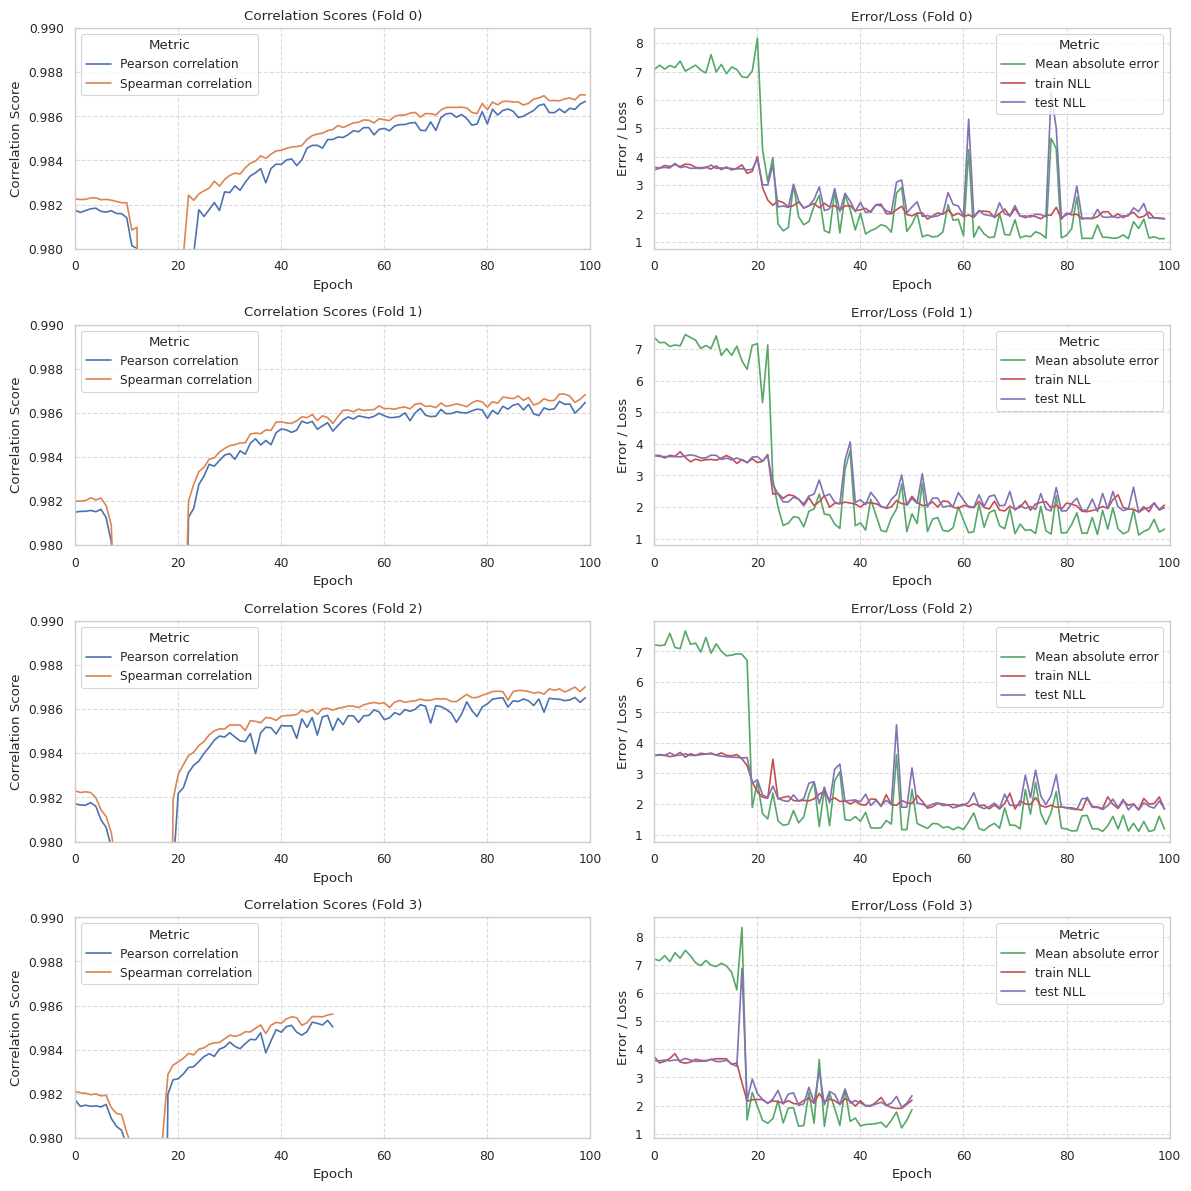

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="paper", style="whitegrid")

folds = sorted(stats['Fold'].unique())
n_folds = len(folds)

fig, axes = plt.subplots(nrows=n_folds, ncols=2, figsize=(12, 12), sharex=False)

for i, fold in enumerate(folds):
    fold_stats = stats[stats['Fold'] == fold]

    palette = sns.color_palette()

    # Plot correlations
    ax = axes[i, 0]

    # Convert to long format
    fold_stats_long = fold_stats.melt(
        id_vars='Epoch',
        value_vars=['Pearson correlation', 'Spearman correlation'],
        var_name='Metric',
        value_name='Correlation'
    )

    sns.lineplot(
        data=fold_stats_long,
        x='Epoch',
        y='Correlation',
        hue='Metric',
        palette={'Pearson correlation': palette[0], 'Spearman correlation': palette[1]},
        ax=ax
    )

    ax.set_title(f'Correlation Scores (Fold {fold})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Correlation Score')
    ax.set_ylim(0.98, 0.99)
    ax.set_xlim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(title='Metric', loc='upper left')

    # Plot errors
    ax = axes[i, 1]

    # Convert to long format
    fold_stats_long = fold_stats.melt(
        id_vars='Epoch',
        value_vars=['Mean absolute error', 'train NLL', 'test NLL'],
        var_name='Error / Loss',
        value_name='Value'
    )

    sns.lineplot(
        data=fold_stats_long,
        x='Epoch',
        y='Value',
        hue='Error / Loss',
        palette={'Mean absolute error': palette[2], 'train NLL': palette[3], 'test NLL': palette[4]},
        ax=ax
    )

    ax.set_title(f'Error/Loss (Fold {fold})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error / Loss')
    # ax.set_ylim(0.98, 0.99)
    ax.set_xlim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(title='Metric', loc='upper right')

plt.tight_layout()
plt.show()
